In [91]:
# TEMPORAL ENERGY CONSUMPTION FORECASTING WITH LIGHTGBM
# Full Dataset Strategy - All 20M+ rows with LCA/PDA Features
# Strict time series validation to prevent data leakage

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import joblib
import gc
import glob
import os
warnings.filterwarnings('ignore')

print("🚀 TEMPORAL ENERGY FORECASTING WITH LIGHTGBM - NEW DATASET")
print("   Full 20M+ row dataset with LCA/PDA features")
print("   Strict chronological validation - NO DATA LEAKAGE")
print("="*80)

🚀 TEMPORAL ENERGY FORECASTING WITH LIGHTGBM - NEW DATASET
   Full 20M+ row dataset with LCA/PDA features
   Strict chronological validation - NO DATA LEAKAGE


In [92]:
df.head()

,building_id,site_id,timestamp,meter_reading,hour,dayofweek,month,is_weekend,is_holiday,air_temperature,...,lag_72h,rolling_mean_24h,rolling_mean_168h,rolling_std_24h,rolling_max_24h,rolling_min_24h,slope_6h,slope_12h,delta_24h,acceleration_6h
0,0,0,2016-01-01 00:00:00,0.0,0,4,1,0,1,25.0,...,577.228577,577.457798,576.827503,106.537727,749.576553,414.972403,NaN,NaN,NaN,NaN
1,0,0,2016-01-01 01:00:00,0.0,1,4,1,0,1,24.4,...,577.228577,0.000000,0.000000,106.537727,0.000000,0.000000,NaN,NaN,NaN,NaN
2,0,0,2016-01-01 02:00:00,0.0,2,4,1,0,1,22.8,...,577.228577,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
3,0,0,2016-01-01 03:00:00,0.0,3,4,1,0,1,21.1,...,577.228577,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
4,0,0,2016-01-01 04:00:00,0.0,4,4,1,0,1,20.0,...,577.228577,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN


In [93]:
df.tail()

,building_id,site_id,timestamp,meter_reading,hour,dayofweek,month,is_weekend,is_holiday,air_temperature,...,lag_72h,rolling_mean_24h,rolling_mean_168h,rolling_std_24h,rolling_max_24h,rolling_min_24h,slope_6h,slope_12h,delta_24h,acceleration_6h
12291394,1448,15,2016-12-31 19:00:00,3.400,19,5,12,1,0,3.0,...,3.800,3.420833,3.294345,0.406113,4.225,2.575,0.008333,0.041667,0.100,0.000000
12291395,1448,15,2016-12-31 20:00:00,2.700,20,5,12,1,0,2.8,...,2.925,3.421875,3.295387,0.406022,4.225,2.575,0.116667,0.018750,0.300,-0.033333
12291396,1448,15,2016-12-31 21:00:00,3.050,21,5,12,1,0,2.8,...,3.200,3.405208,3.290774,0.427453,4.225,2.575,0.020833,-0.039583,-0.525,0.195833
12291397,1448,15,2016-12-31 22:00:00,3.125,22,5,12,1,0,2.2,...,3.475,3.397917,3.288244,0.432128,4.225,2.575,0.012500,-0.079167,-1.175,0.258333
12291398,1448,15,2016-12-31 23:00:00,2.850,23,5,12,1,0,1.7,...,2.925,3.352083,3.287202,0.397541,4.000,2.575,-0.141667,-0.047917,-0.200,0.133333


In [94]:
# 1. LOAD AND VALIDATE PREPROCESSED DATASET
print("\n1. LOADING PREPROCESSED DATASET WITH LCA/PDA FEATURES")
print("-"*80)

# Find the most recent preprocessed dataset
data_files = glob.glob('../data/energy_processed_fulldata_*.csv')

if not data_files:
    print("   ❌ No preprocessed dataset found!")
    print("   Please run preprocessing.ipynb first!")
    raise FileNotFoundError("Preprocessed dataset not found")

# Get most recent file
latest_file = max(data_files, key=os.path.getctime)
print(f"   📁 Loading: {os.path.basename(latest_file)}")

df = pd.read_csv(latest_file)

# Convert timestamp and data types
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['building_id'] = df['building_id'].astype('int16')

print(f"   ✓ Dataset loaded: {df.shape}")
print(f"   ✓ Memory usage: {df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
print(f"   ✓ Buildings: {df['building_id'].nunique()}")
print(f"   ✓ Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"   ✓ Columns: {len(df.columns)}")


1. LOADING PREPROCESSED DATASET WITH LCA/PDA FEATURES
--------------------------------------------------------------------------------
   📁 Loading: energy_processed_fulldata_20251109_175759.csv
   ✓ Dataset loaded: (12291399, 31)
   ✓ Memory usage: 2.77 GB
   ✓ Buildings: 1449
   ✓ Date range: 2016-01-01 00:00:00 to 2016-12-31 23:00:00
   ✓ Columns: 31
   ✓ Dataset loaded: (12291399, 31)
   ✓ Memory usage: 2.77 GB
   ✓ Buildings: 1449
   ✓ Date range: 2016-01-01 00:00:00 to 2016-12-31 23:00:00
   ✓ Columns: 31


In [95]:
# 2. TEMPORAL VALIDATION (PREVENT DATA LEAKAGE)
print("\n2. TEMPORAL VALIDATION & DATA LEAKAGE PREVENTION")
print("-"*80)

# Verify chronological order
is_chronological = df['timestamp'].is_monotonic_increasing
per_building_chrono = df.groupby('building_id')['timestamp'].is_monotonic_increasing.all()

print(f"   ✓ Global chronological order: {is_chronological}")
print(f"   ✓ Per-building chronological order: {per_building_chrono}")

# Check for duplicates
duplicates = df.duplicated(subset=['building_id', 'timestamp']).sum()
print(f"   ✓ Duplicate timestamps per building: {duplicates}")

# Ensure proper ordering for train/test split
if not is_chronological:
    print("   ⚠️  Sorting chronologically...")
    df = df.sort_values(['timestamp', 'building_id']).reset_index(drop=True)

# Sort within each building to ensure causality
df = df.sort_values(['building_id', 'timestamp']).reset_index(drop=True)

print(f"   🔒 Data properly ordered for temporal train/test split")


2. TEMPORAL VALIDATION & DATA LEAKAGE PREVENTION
--------------------------------------------------------------------------------
   ✓ Global chronological order: True
   ✓ Per-building chronological order: True
   ✓ Global chronological order: True
   ✓ Per-building chronological order: True
   ✓ Duplicate timestamps per building: 0
   ✓ Duplicate timestamps per building: 0
   🔒 Data properly ordered for temporal train/test split
   🔒 Data properly ordered for temporal train/test split


In [96]:
# 3. FEATURE IDENTIFICATION AND CATEGORIZATION
print("\n3. FEATURE IDENTIFICATION & CATEGORIZATION")
print("-"*80)

# Separate features by type - only include columns that actually exist
building_features = [col for col in df.columns if col in ['square_feet', 'year_built', 'building_age', 'primary_use_encoded']]
temporal_features = [col for col in df.columns if col in ['hour', 'dayofweek', 'month', 'quarter', 'is_weekend', 'dayofmonth']]
calendar_features = [col for col in df.columns if col in ['is_holiday', 'near_holiday']]
weather_features = [col for col in df.columns if col in ['air_temperature', 'dew_temperature', 'wind_speed', 'CDD', 'HDD']]
lag_features = [col for col in df.columns if 'lag_' in col]
rolling_features = [col for col in df.columns if 'rolling_' in col]
lca_features = [col for col in df.columns if 'lca_' in col]
pda_features = [col for col in df.columns if 'pda_' in col]

# Combine all modeling features
model_features = (building_features + temporal_features + calendar_features + weather_features + 
                   lag_features + rolling_features + lca_features + pda_features)
categorical_features = ['building_id', 'site_id']

print(f"   ✓ Total features: {len(model_features)}")


3. FEATURE IDENTIFICATION & CATEGORIZATION
--------------------------------------------------------------------------------
   ✓ Total features: 18


In [97]:
# 4. HANDLE MISSING VALUES & ENCODE CATEGORICAL FEATURES
print("\n4. MISSING VALUE CHECK & CATEGORICAL ENCODING")
print("-"*80)

# Filter to available features
model_features_available = [col for col in model_features if col in df.columns]
model_features = model_features_available

# Fill missing values
missing_total = df[model_features].isnull().sum().sum()
if missing_total > 0:
    for col in model_features:
        df[col].fillna(df[col].mean(), inplace=True)

# Encode categorical
for col in df[model_features].select_dtypes(include=['object']).columns:
    df[col] = pd.factorize(df[col])[0]

print(f"   ✓ Preprocessing complete: {len(model_features)} features ready")


4. MISSING VALUE CHECK & CATEGORICAL ENCODING
--------------------------------------------------------------------------------
   ✓ Preprocessing complete: 18 features ready
   ✓ Preprocessing complete: 18 features ready


In [98]:
# 5. TEMPORAL TRAIN/TEST SPLIT (CHRONOLOGICAL) & DIAGNOSTICS
print("\n5. TEMPORAL TRAIN/TEST SPLIT (NO LEAKAGE)")
print("-"*80)

# Get total time span
total_days = (df['timestamp'].max() - df['timestamp'].min()).days
train_ratio = 0.7  # 70% train, 30% test
split_date = df['timestamp'].min() + pd.Timedelta(days=int(total_days * train_ratio))

# Split chronologically
train_df = df[df['timestamp'] < split_date].copy()
test_df = df[df['timestamp'] >= split_date].copy()

print(f"   ✓ Total timespan: {total_days} days")
print(f"   ✓ Split date: {split_date}")
print(f"   ✓ Train set: {len(train_df):,} rows ({len(train_df)/len(df)*100:.1f}%)")
print(f"   ✓ Test set: {len(test_df):,} rows ({len(test_df)/len(df)*100:.1f}%)")
print(f"   ✓ Train period: {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")
print(f"   ✓ Test period: {test_df['timestamp'].min()} to {test_df['timestamp'].max()}")

# Verify no overlap
assert train_df['timestamp'].max() < test_df['timestamp'].min(), "⚠️  Data leakage detected!"
print(f"   🔒 No temporal leakage - test data is strictly AFTER train data")

# DIAGNOSTIC: Compare target distribution
print(f"\n   📊 TARGET DISTRIBUTION COMPARISON:")
train_target_stats = train_df['meter_reading'].describe()
test_target_stats = test_df['meter_reading'].describe()

print(f"   Train - Mean: {train_target_stats['mean']:.2f}, Std: {train_target_stats['std']:.2f}, IQR: {train_target_stats['75%'] - train_target_stats['25%']:.2f}")
print(f"   Test  - Mean: {test_target_stats['mean']:.2f}, Std: {test_target_stats['std']:.2f}, IQR: {test_target_stats['75%'] - test_target_stats['25%']:.2f}")

# Check for distributional shift
std_diff_pct = abs(train_target_stats['std'] - test_target_stats['std']) / train_target_stats['std'] * 100
mean_diff_pct = abs(train_target_stats['mean'] - test_target_stats['mean']) / train_target_stats['mean'] * 100
print(f"   Std difference: {std_diff_pct:.1f}% | Mean difference: {mean_diff_pct:.1f}%")

if std_diff_pct > 20:
    print(f"   ⚠️  WARNING: Significant distributional shift in test period")

# Prepare X and y
X_train = train_df[model_features].copy()
y_train = train_df['meter_reading'].copy()
X_test = test_df[model_features].copy()
y_test = test_df['meter_reading'].copy()

# Add categorical features
X_train['building_id'] = train_df['building_id'].astype('int16')
X_train['site_id'] = train_df['site_id'].astype('int8')
X_test['building_id'] = test_df['building_id'].astype('int16')
X_test['site_id'] = test_df['site_id'].astype('int8')

# Update model_features to include categorical
model_features_all = model_features + ['building_id', 'site_id']

print(f"\n   Feature matrix shapes:")
print(f"   ✓ X_train: {X_train.shape}")
print(f"   ✓ y_train: {y_train.shape}")
print(f"   ✓ X_test: {X_test.shape}")
print(f"   ✓ y_test: {y_test.shape}")


5. TEMPORAL TRAIN/TEST SPLIT (NO LEAKAGE)
--------------------------------------------------------------------------------
   ✓ Total timespan: 365 days
   ✓ Split date: 2016-09-12 00:00:00
   ✓ Train set: 8,513,207 rows (69.3%)
   ✓ Test set: 3,778,192 rows (30.7%)
   ✓ Train period: 2016-01-01 00:00:00 to 2016-09-11 23:00:00
   ✓ Test period: 2016-09-12 00:00:00 to 2016-12-31 23:00:00
   🔒 No temporal leakage - test data is strictly AFTER train data

   📊 TARGET DISTRIBUTION COMPARISON:
   Train - Mean: 574.57, Std: 1391.57, IQR: 409.11
   Test  - Mean: 584.37, Std: 1378.19, IQR: 419.11
   Std difference: 1.0% | Mean difference: 1.7%
   ✓ Total timespan: 365 days
   ✓ Split date: 2016-09-12 00:00:00
   ✓ Train set: 8,513,207 rows (69.3%)
   ✓ Test set: 3,778,192 rows (30.7%)
   ✓ Train period: 2016-01-01 00:00:00 to 2016-09-11 23:00:00
   ✓ Test period: 2016-09-12 00:00:00 to 2016-12-31 23:00:00
   🔒 No temporal leakage - test data is strictly AFTER train data

   📊 TARGET DISTRIBUT

In [99]:
# 6. LIGHTGBM MODEL TRAINING WITH CATEGORICAL SUPPORT
print("\n6. LIGHTGBM MODEL TRAINING WITH CATEGORICAL FEATURES")
print("-"*80)

# Create LightGBM datasets with categorical features
train_data = lgb.Dataset(X_train[model_features_all], label=y_train)
test_data = lgb.Dataset(X_test[model_features_all], label=y_test, reference=train_data)

# Set feature names
train_data.feature_names = model_features_all

# Specify categorical features (LightGBM will use optimal categorical splits)
categorical_indices = [model_features_all.index('building_id'), model_features_all.index('site_id')]
train_data.categorical_feature = categorical_indices

print(f"   Categorical features: {[model_features_all[i] for i in categorical_indices]}")

# LightGBM parameters optimized for time series with categorical support
# IMPROVED: Increased regularization to reduce overfitting (close train/test gap)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 48,           # Reduced from 64 to prevent overfitting
    'max_depth': 8,             # Reduced from 10 to prevent overfitting
    'learning_rate': 0.02,
    'feature_fraction': 0.80,   # Reduced from 0.85 for more regularization
    'bagging_fraction': 0.80,   # Reduced from 0.85 for more regularization
    'bagging_freq': 5,
    'min_data_in_leaf': 50,     # Increased from 20 to prevent overfitting
    'lambda_l1': 0.3,           # Increased from 0.1 for L1 regularization
    'lambda_l2': 0.3,           # Increased from 0.1 for L2 regularization
    'min_gain_to_split': 0.01,  # Added: minimum gain required to split
    'verbosity': -1,
    'seed': 42,
    'n_jobs': -1,
    'categorical_feature': categorical_indices  # Pass to params too
}

print(f"   Training parameters:")
for key, val in params.items():
    if key != 'categorical_feature':
        print(f"     {key}: {val}")

# Train model with early stopping
print(f"\n   Training model on {len(X_train):,} samples...")
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'test'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)

print(f"   ✓ Model trained successfully")
print(f"   ✓ Best iteration: {model.best_iteration}")


6. LIGHTGBM MODEL TRAINING WITH CATEGORICAL FEATURES
--------------------------------------------------------------------------------
   Categorical features: ['building_id', 'site_id']
   Training parameters:
     objective: regression
     metric: rmse
     num_leaves: 48
     max_depth: 8
     learning_rate: 0.02
     feature_fraction: 0.8
     bagging_fraction: 0.8
     bagging_freq: 5
     min_data_in_leaf: 50
     lambda_l1: 0.3
     lambda_l2: 0.3
     min_gain_to_split: 0.01
     verbosity: -1
     seed: 42
     n_jobs: -1

   Training model on 8,513,207 samples...
   Categorical features: ['building_id', 'site_id']
   Training parameters:
     objective: regression
     metric: rmse
     num_leaves: 48
     max_depth: 8
     learning_rate: 0.02
     feature_fraction: 0.8
     bagging_fraction: 0.8
     bagging_freq: 5
     min_data_in_leaf: 50
     lambda_l1: 0.3
     lambda_l2: 0.3
     min_gain_to_split: 0.01
     verbosity: -1
     seed: 42
     n_jobs: -1

   Training mod

In [100]:
# 7. MODEL EVALUATION WITH BASELINES & ROBUST METRICS
print("\n7. MODEL EVALUATION WITH BASELINES")
print("-"*80)

# Predictions
y_train_pred = model.predict(X_train[model_features_all])
y_test_pred = model.predict(X_test[model_features_all])

# Calculate robust metrics (avoiding MAPE due to zeros)
def calc_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # WAPE: Weighted Absolute Percentage Error (robust to zeros)
    wape = np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100
    
    # sMAPE: Symmetric MAPE (robust to zeros)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)
    # Avoid division by zero
    smape = np.mean(np.where(denominator > 0, diff / denominator, 0)) * 100
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'WAPE': wape, 'sMAPE': smape}

train_metrics = calc_metrics(y_train, y_train_pred)
test_metrics = calc_metrics(y_test, y_test_pred)

print(f"\n   TRAIN SET PERFORMANCE:")
print(f"     RMSE:  {train_metrics['RMSE']:.4f} kWh")
print(f"     MAE:   {train_metrics['MAE']:.4f} kWh")
print(f"     WAPE:  {train_metrics['WAPE']:.2f}%")
print(f"     sMAPE: {train_metrics['sMAPE']:.2f}%")
print(f"     R²:    {train_metrics['R2']:.4f}")

print(f"\n   TEST SET PERFORMANCE:")
print(f"     RMSE:  {test_metrics['RMSE']:.4f} kWh")
print(f"     MAE:   {test_metrics['MAE']:.4f} kWh")
print(f"     WAPE:  {test_metrics['WAPE']:.2f}%")
print(f"     sMAPE: {test_metrics['sMAPE']:.2f}%")
print(f"     R²:    {test_metrics['R2']:.4f}")

# BASELINE COMPARISONS
print(f"\n   ⚙️  BASELINE MODEL COMPARISONS:")

# Baseline 1: Persistence (lag_1h)
y_test_baseline_1h = test_df[model_features].get('lag_1h', y_test.mean()) if 'lag_1h' in X_test.columns else y_test.shift(1).fillna(y_test.mean())
baseline_1h_rmse = np.sqrt(mean_squared_error(y_test, y_test_baseline_1h))
baseline_1h_mae = mean_absolute_error(y_test, y_test_baseline_1h)
print(f"     Persistence (1h lag):  RMSE={baseline_1h_rmse:.4f}, MAE={baseline_1h_mae:.4f}")

# Baseline 2: 24h seasonal persistence
y_test_baseline_24h = X_test['lag_24h'].fillna(y_test.mean()) if 'lag_24h' in X_test.columns else y_test.shift(24).fillna(y_test.mean())
baseline_24h_rmse = np.sqrt(mean_squared_error(y_test, y_test_baseline_24h))
baseline_24h_mae = mean_absolute_error(y_test, y_test_baseline_24h)
print(f"     Seasonal (24h lag):    RMSE={baseline_24h_rmse:.4f}, MAE={baseline_24h_mae:.4f}")

# Baseline 3: Rolling mean
y_test_baseline_rolling = X_test['rolling_mean_24h'].fillna(y_test.mean())
baseline_rolling_rmse = np.sqrt(mean_squared_error(y_test, y_test_baseline_rolling))
baseline_rolling_mae = mean_absolute_error(y_test, y_test_baseline_rolling)
print(f"     Rolling mean (24h):    RMSE={baseline_rolling_rmse:.4f}, MAE={baseline_rolling_mae:.4f}")

# Compare to LightGBM
print(f"\n   📊 LightGBM vs Baselines:")
improvement_1h = (baseline_1h_rmse - test_metrics['RMSE']) / baseline_1h_rmse * 100
improvement_24h = (baseline_24h_rmse - test_metrics['RMSE']) / baseline_24h_rmse * 100
improvement_rolling = (baseline_rolling_rmse - test_metrics['RMSE']) / baseline_rolling_rmse * 100

print(f"     vs 1h persistence:    {improvement_1h:+.1f}% (LightGBM {'better' if improvement_1h > 0 else 'worse'})")
print(f"     vs 24h seasonal:      {improvement_24h:+.1f}% (LightGBM {'better' if improvement_24h > 0 else 'worse'})")
print(f"     vs rolling mean:      {improvement_rolling:+.1f}% (LightGBM {'better' if improvement_rolling > 0 else 'worse'})")

# Check for overfitting
rmse_ratio = test_metrics['RMSE'] / train_metrics['RMSE']
print(f"\n   🔍 OVERFITTING ANALYSIS:")
print(f"     Test/Train RMSE ratio: {rmse_ratio:.4f}")
if rmse_ratio > 1.1:
    print(f"     ⚠️  Potential overfitting (ratio > 1.1)")
elif rmse_ratio < 0.9:
    print(f"     ⚠️  Test better than train - likely distributional shift or lag contamination")
else:
    print(f"     ✓ Reasonable generalization")


7. MODEL EVALUATION WITH BASELINES
--------------------------------------------------------------------------------

   TRAIN SET PERFORMANCE:
     RMSE:  167.7280 kWh
     MAE:   42.7785 kWh
     WAPE:  7.45%
     sMAPE: 24.14%
     R²:    0.9855

   TEST SET PERFORMANCE:
     RMSE:  182.2918 kWh
     MAE:   47.4230 kWh
     WAPE:  8.12%
     sMAPE: 17.95%
     R²:    0.9825

   ⚙️  BASELINE MODEL COMPARISONS:
     Persistence (1h lag):  RMSE=206.7666, MAE=45.4095
     Seasonal (24h lag):    RMSE=365.6088, MAE=93.2569
     Rolling mean (24h):    RMSE=322.6445, MAE=99.8879

   📊 LightGBM vs Baselines:
     vs 1h persistence:    +11.8% (LightGBM better)
     vs 24h seasonal:      +50.1% (LightGBM better)
     vs rolling mean:      +43.5% (LightGBM better)

   🔍 OVERFITTING ANALYSIS:
     Test/Train RMSE ratio: 1.0868
     ✓ Reasonable generalization

   TRAIN SET PERFORMANCE:
     RMSE:  167.7280 kWh
     MAE:   42.7785 kWh
     WAPE:  7.45%
     sMAPE: 24.14%
     R²:    0.9855

   TE

In [101]:
# 8. FEATURE IMPORTANCE ANALYSIS
print("\n8. FEATURE IMPORTANCE ANALYSIS")
print("-"*80)

# Get feature importance
feature_importance = model.feature_importance()
feature_names = model.feature_name()

# Create dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\n   Top 15 most important features:")
for idx, row in importance_df.head(15).iterrows():
    print(f"     {row['feature']:30s} : {row['importance']:6.0f}")

print(f"\n   Feature importance by category:")
categories_importance = {}
for _, row in importance_df.iterrows():
    feature = row['feature']
    importance = row['importance']
    
    if 'lag_' in feature:
        cat = 'Lag Features'
    elif 'rolling_' in feature:
        cat = 'Rolling Statistics'
    elif 'lca_' in feature:
        cat = 'LCA Components'
    elif 'pda_' in feature:
        cat = 'PDA Components'
    elif feature in temporal_features:
        cat = 'Temporal Features'
    elif feature in weather_features:
        cat = 'Weather Features'
    elif feature in building_features:
        cat = 'Building Features'
    else:
        cat = 'Other'
    
    categories_importance[cat] = categories_importance.get(cat, 0) + importance

print(f"\n   Importance by category:")
for cat in sorted(categories_importance.keys(), key=lambda x: categories_importance[x], reverse=True):
    pct = (categories_importance[cat] / sum(categories_importance.values())) * 100
    print(f"     {cat:25s} : {categories_importance[cat]:8.0f} ({pct:5.1f}%)")


8. FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------------------------------------

   Top 15 most important features:
     building_id                    :   6551
     lag_1h                         :   3515
     hour                           :   2809
     lag_24h                        :   2566
     lag_3h                         :   1961
     lag_72h                        :   1191
     lag_6h                         :   1049
     rolling_std_24h                :   1039
     rolling_mean_24h               :   1027
     air_temperature                :   1020
     dayofweek                      :    845
     rolling_min_24h                :    725
     rolling_max_24h                :    498
     rolling_mean_168h              :    487
     site_id                        :    442

   Feature importance by category:

   Importance by category:
     Lag Features              :    10282 ( 38.5%)
     Other                     :     7044 ( 26.4%)
     Tempo

In [102]:
# 9. SAVE MODEL & TEMPORAL-BASED DIAGNOSTICS
print("\n9. SAVING MODEL & TEMPORAL DIAGNOSTICS")
print("-"*80)

# Save model
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = f'../models/lgbm_temporal_energy_fulldata_{timestamp}.pkl'
model.save_model(model_path)
print(f"   ✓ Model saved: {model_path}")

# TEMPORAL-BASED ANALYSIS (not building-based)
test_analysis = test_df[['timestamp', 'building_id', 'meter_reading']].copy()
test_analysis['prediction'] = y_test_pred
test_analysis['residual'] = y_test - y_test_pred
test_analysis['abs_error'] = np.abs(test_analysis['residual'])

# Aggregate by timestamp (temporal patterns, not building patterns)
temporal_metrics = test_analysis.groupby('timestamp').agg({
    'meter_reading': ['mean', 'std'],
    'prediction': 'mean',
    'abs_error': ['mean', 'max'],
    'residual': 'mean'
}).reset_index()
temporal_metrics.columns = ['timestamp', 'actual_mean', 'actual_std', 'pred_mean', 'mae', 'max_error', 'bias']

# Add temporal features for analysis
temporal_metrics['hour'] = temporal_metrics['timestamp'].dt.hour
temporal_metrics['dayofweek'] = temporal_metrics['timestamp'].dt.dayofweek
temporal_metrics['date'] = temporal_metrics['timestamp'].dt.date

# Save temporal metrics
temporal_metrics_path = f'../reports/temporal_metrics_{timestamp}.csv'
temporal_metrics.to_csv(temporal_metrics_path, index=False)
print(f"   ✓ Temporal metrics saved: {temporal_metrics_path}")

# Hourly performance analysis
print(f"\n   📊 PERFORMANCE BY HOUR OF DAY:")
hourly_perf = test_analysis.groupby(test_analysis['timestamp'].dt.hour)['abs_error'].mean()
for hour in range(24):
    if hour in hourly_perf.index:
        print(f"     Hour {hour:02d}: MAE = {hourly_perf[hour]:.2f} kWh")

# Day of week performance
print(f"\n   📊 PERFORMANCE BY DAY OF WEEK:")
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_perf = test_analysis.groupby(test_analysis['timestamp'].dt.dayofweek)['abs_error'].mean()
for dow in range(7):
    if dow in dow_perf.index:
        print(f"     {dow_names[dow]}: MAE = {dow_perf[dow]:.2f} kWh")

# Time-based error patterns
print(f"\n   📊 TEMPORAL ERROR PATTERNS:")
print(f"     Best hour: {hourly_perf.idxmin():02d}:00 (MAE={hourly_perf.min():.2f})")
print(f"     Worst hour: {hourly_perf.idxmax():02d}:00 (MAE={hourly_perf.max():.2f})")
print(f"     Best day: {dow_names[dow_perf.idxmin()]} (MAE={dow_perf.min():.2f})")
print(f"     Worst day: {dow_names[dow_perf.idxmax()]} (MAE={dow_perf.max():.2f})")

# Save results summary
results = {
    'timestamp': timestamp,
    'dataset_size': len(df),
    'num_features': len(model_features_all),
    'num_buildings': df['building_id'].nunique(),
    'train_size': len(train_df),
    'test_size': len(test_df),
    'train_rmse': float(train_metrics['RMSE']),
    'test_rmse': float(test_metrics['RMSE']),
    'train_mae': float(train_metrics['MAE']),
    'test_mae': float(test_metrics['MAE']),
    'train_r2': float(train_metrics['R2']),
    'test_r2': float(test_metrics['R2']),
    'test_wape': float(test_metrics['WAPE']),
    'test_smape': float(test_metrics['sMAPE']),
    'best_iteration': int(model.best_iteration),
    'baseline_1h_rmse': float(baseline_1h_rmse),
    'baseline_24h_rmse': float(baseline_24h_rmse),
    'improvement_vs_1h': float(improvement_1h),
    'improvement_vs_24h': float(improvement_24h),
    'hourly_performance': hourly_perf.to_dict(),
    'daily_performance': dow_perf.to_dict(),
    'features': model_features_all
}

# Save results
import json
results_path = f'../models/lgbm_results_{timestamp}.json'
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2, default=str)
print(f"   ✓ Results saved: {results_path}")

# Save feature importance
importance_df = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)

importance_path = f'../reports/feature_importance_{timestamp}.csv'
importance_df.to_csv(importance_path, index=False)
print(f"   ✓ Feature importance saved: {importance_path}")

print(f"\n   📊 FINAL SUMMARY:")
print(f"     Test RMSE:  {test_metrics['RMSE']:.2f} kWh")
print(f"     Test MAE:   {test_metrics['MAE']:.2f} kWh")
print(f"     Test WAPE:  {test_metrics['WAPE']:.2f}%")
print(f"     Test R²:    {test_metrics['R2']:.4f}")


9. SAVING MODEL & TEMPORAL DIAGNOSTICS
--------------------------------------------------------------------------------
   ✓ Model saved: ../models/lgbm_temporal_energy_fulldata_20251109_200645.pkl
   ✓ Temporal metrics saved: ../reports/temporal_metrics_20251109_200645.csv

   📊 PERFORMANCE BY HOUR OF DAY:
   ✓ Temporal metrics saved: ../reports/temporal_metrics_20251109_200645.csv

   📊 PERFORMANCE BY HOUR OF DAY:
     Hour 00: MAE = 43.44 kWh
     Hour 01: MAE = 41.49 kWh
     Hour 02: MAE = 39.07 kWh
     Hour 03: MAE = 38.97 kWh
     Hour 04: MAE = 40.71 kWh
     Hour 05: MAE = 44.64 kWh
     Hour 06: MAE = 51.72 kWh
     Hour 07: MAE = 56.14 kWh
     Hour 08: MAE = 53.00 kWh
     Hour 09: MAE = 52.56 kWh
     Hour 10: MAE = 53.37 kWh
     Hour 11: MAE = 53.08 kWh
     Hour 12: MAE = 50.93 kWh
     Hour 13: MAE = 48.74 kWh
     Hour 14: MAE = 47.51 kWh
     Hour 15: MAE = 48.45 kWh
     Hour 16: MAE = 47.99 kWh
     Hour 17: MAE = 48.58 kWh
     Hour 18: MAE = 49.23 kWh
     Hour


10. TEMPORAL VISUALIZATIONS
--------------------------------------------------------------------------------
   ✓ Temporal visualization saved: ../reports/temporal_analysis_20251109_200645.png
   ✓ Temporal visualization saved: ../reports/temporal_analysis_20251109_200645.png


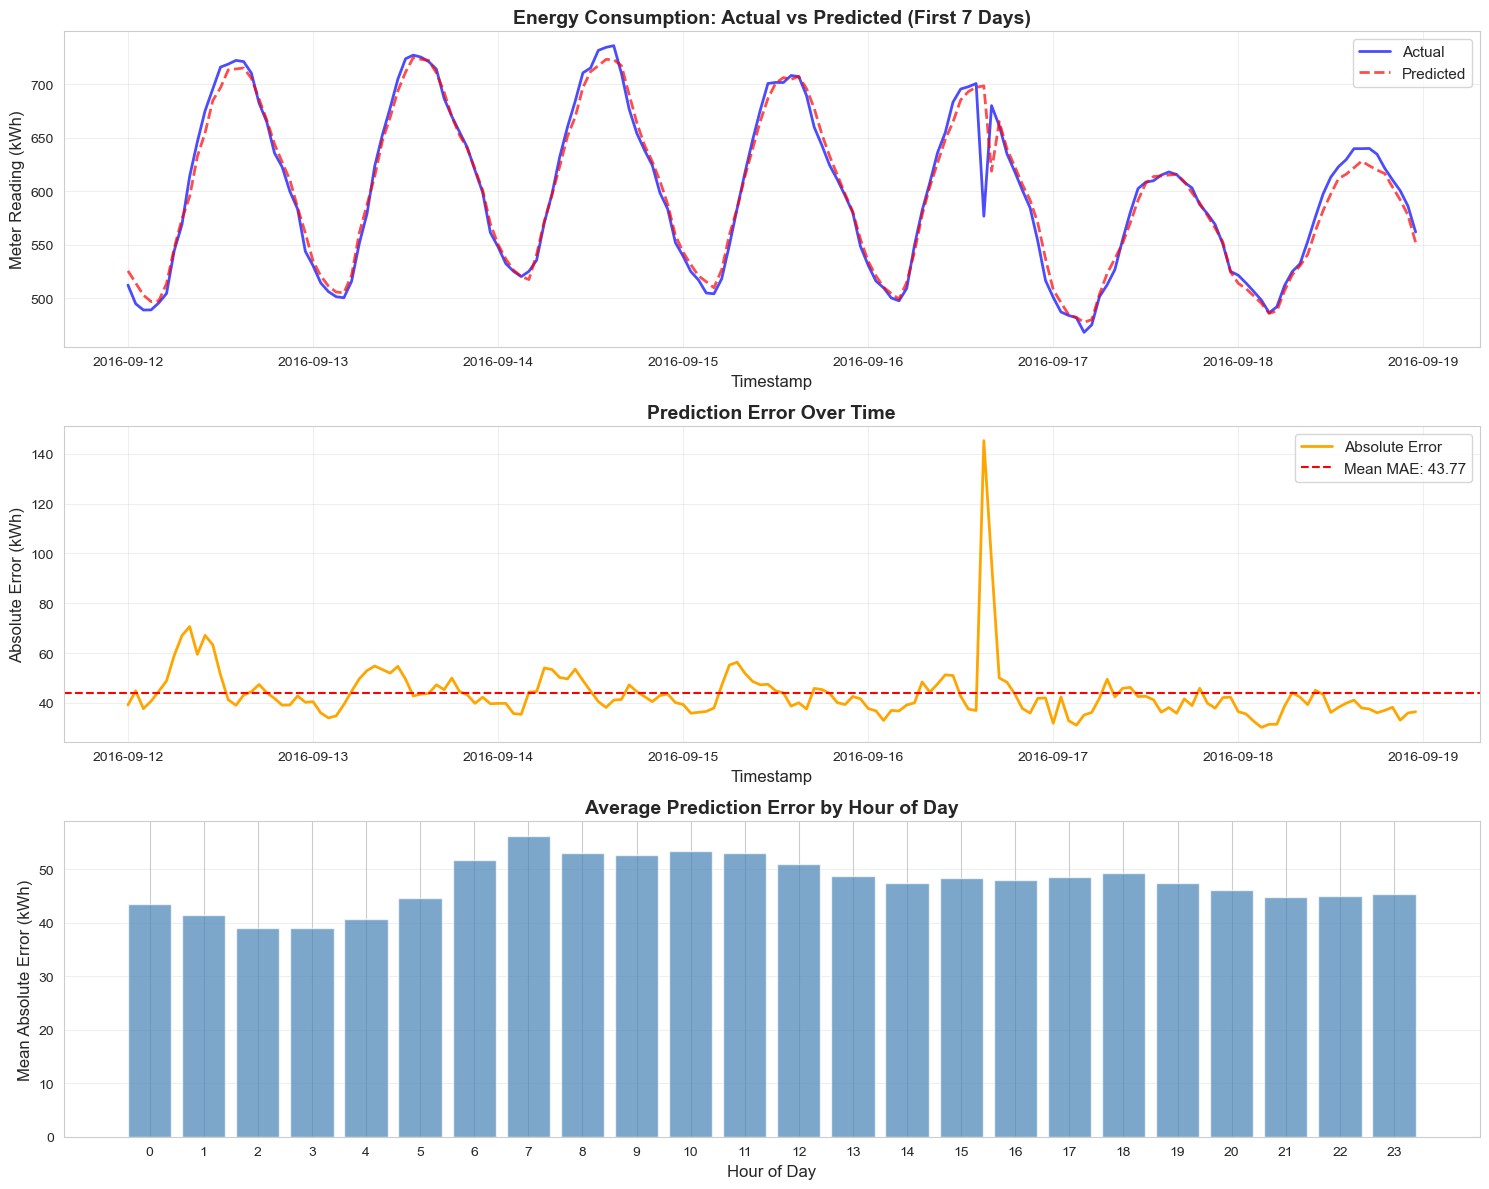

   ✓ Weekly analysis saved: ../reports/weekly_analysis_20251109_200645.png


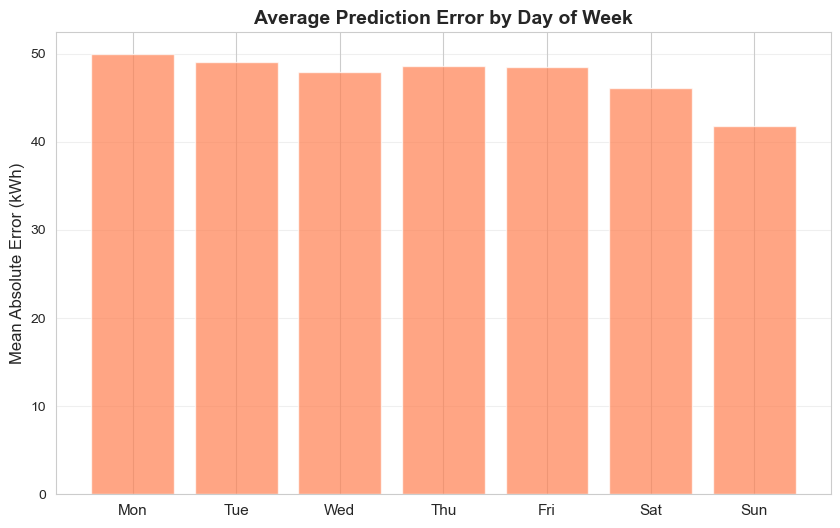


✅ Temporal-based analysis complete!
   Focus: Time patterns (not building IDs)
   Visualizations: Time-series plots showing temporal trends


In [103]:
# 10. TEMPORAL VISUALIZATIONS - TIME-SERIES PLOTS
print("\n10. TEMPORAL VISUALIZATIONS")
print("-"*80)

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create temporal analysis dataframe
temp_viz = test_analysis.groupby('timestamp').agg({
    'meter_reading': 'mean',
    'prediction': 'mean',
    'abs_error': 'mean'
}).reset_index()

# Sample for visualization (first 7 days of test set)
viz_days = 7
sample_hours = viz_days * 24
temp_viz_sample = temp_viz.head(sample_hours)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Actual vs Predicted over time
axes[0].plot(temp_viz_sample['timestamp'], temp_viz_sample['meter_reading'], 
             label='Actual', color='blue', linewidth=2, alpha=0.7)
axes[0].plot(temp_viz_sample['timestamp'], temp_viz_sample['prediction'], 
             label='Predicted', color='red', linewidth=2, linestyle='--', alpha=0.7)
axes[0].set_title(f'Energy Consumption: Actual vs Predicted (First {viz_days} Days)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Timestamp', fontsize=12)
axes[0].set_ylabel('Meter Reading (kWh)', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Error over time
axes[1].plot(temp_viz_sample['timestamp'], temp_viz_sample['abs_error'], 
             label='Absolute Error', color='orange', linewidth=2)
axes[1].axhline(y=temp_viz_sample['abs_error'].mean(), color='red', linestyle='--', 
                label=f'Mean MAE: {temp_viz_sample["abs_error"].mean():.2f}')
axes[1].set_title('Prediction Error Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Timestamp', fontsize=12)
axes[1].set_ylabel('Absolute Error (kWh)', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

# Plot 3: Hourly performance
temp_viz['hour'] = temp_viz['timestamp'].dt.hour
hourly_mae = temp_viz.groupby('hour')['abs_error'].mean()
axes[2].bar(hourly_mae.index, hourly_mae.values, color='steelblue', alpha=0.7)
axes[2].set_title('Average Prediction Error by Hour of Day', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Hour of Day', fontsize=12)
axes[2].set_ylabel('Mean Absolute Error (kWh)', fontsize=12)
axes[2].set_xticks(range(24))
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plot_path = f'../reports/temporal_analysis_{timestamp}.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"   ✓ Temporal visualization saved: {plot_path}")
plt.show()

# Additional: Day of week analysis
fig2, ax = plt.subplots(1, 1, figsize=(10, 6))
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
temp_viz['dayofweek'] = temp_viz['timestamp'].dt.dayofweek
dow_mae = temp_viz.groupby('dayofweek')['abs_error'].mean()

ax.bar(range(7), [dow_mae.get(i, 0) for i in range(7)], 
       color='coral', alpha=0.7)
ax.set_xticks(range(7))
ax.set_xticklabels(dow_names, fontsize=11)
ax.set_title('Average Prediction Error by Day of Week', fontsize=14, fontweight='bold')
ax.set_ylabel('Mean Absolute Error (kWh)', fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

plot_path2 = f'../reports/weekly_analysis_{timestamp}.png'
plt.savefig(plot_path2, dpi=300, bbox_inches='tight')
print(f"   ✓ Weekly analysis saved: {plot_path2}")
plt.show()

print(f"\n✅ Temporal-based analysis complete!")
print(f"   Focus: Time patterns (not building IDs)")
print(f"   Visualizations: Time-series plots showing temporal trends")


11. COMPREHENSIVE PERFORMANCE ANALYSIS & VISUALIZATIONS
--------------------------------------------------------------------------------
   ✓ Comprehensive analysis saved: ../reports/comprehensive_analysis_20251109_200645.png
   ✓ Comprehensive analysis saved: ../reports/comprehensive_analysis_20251109_200645.png


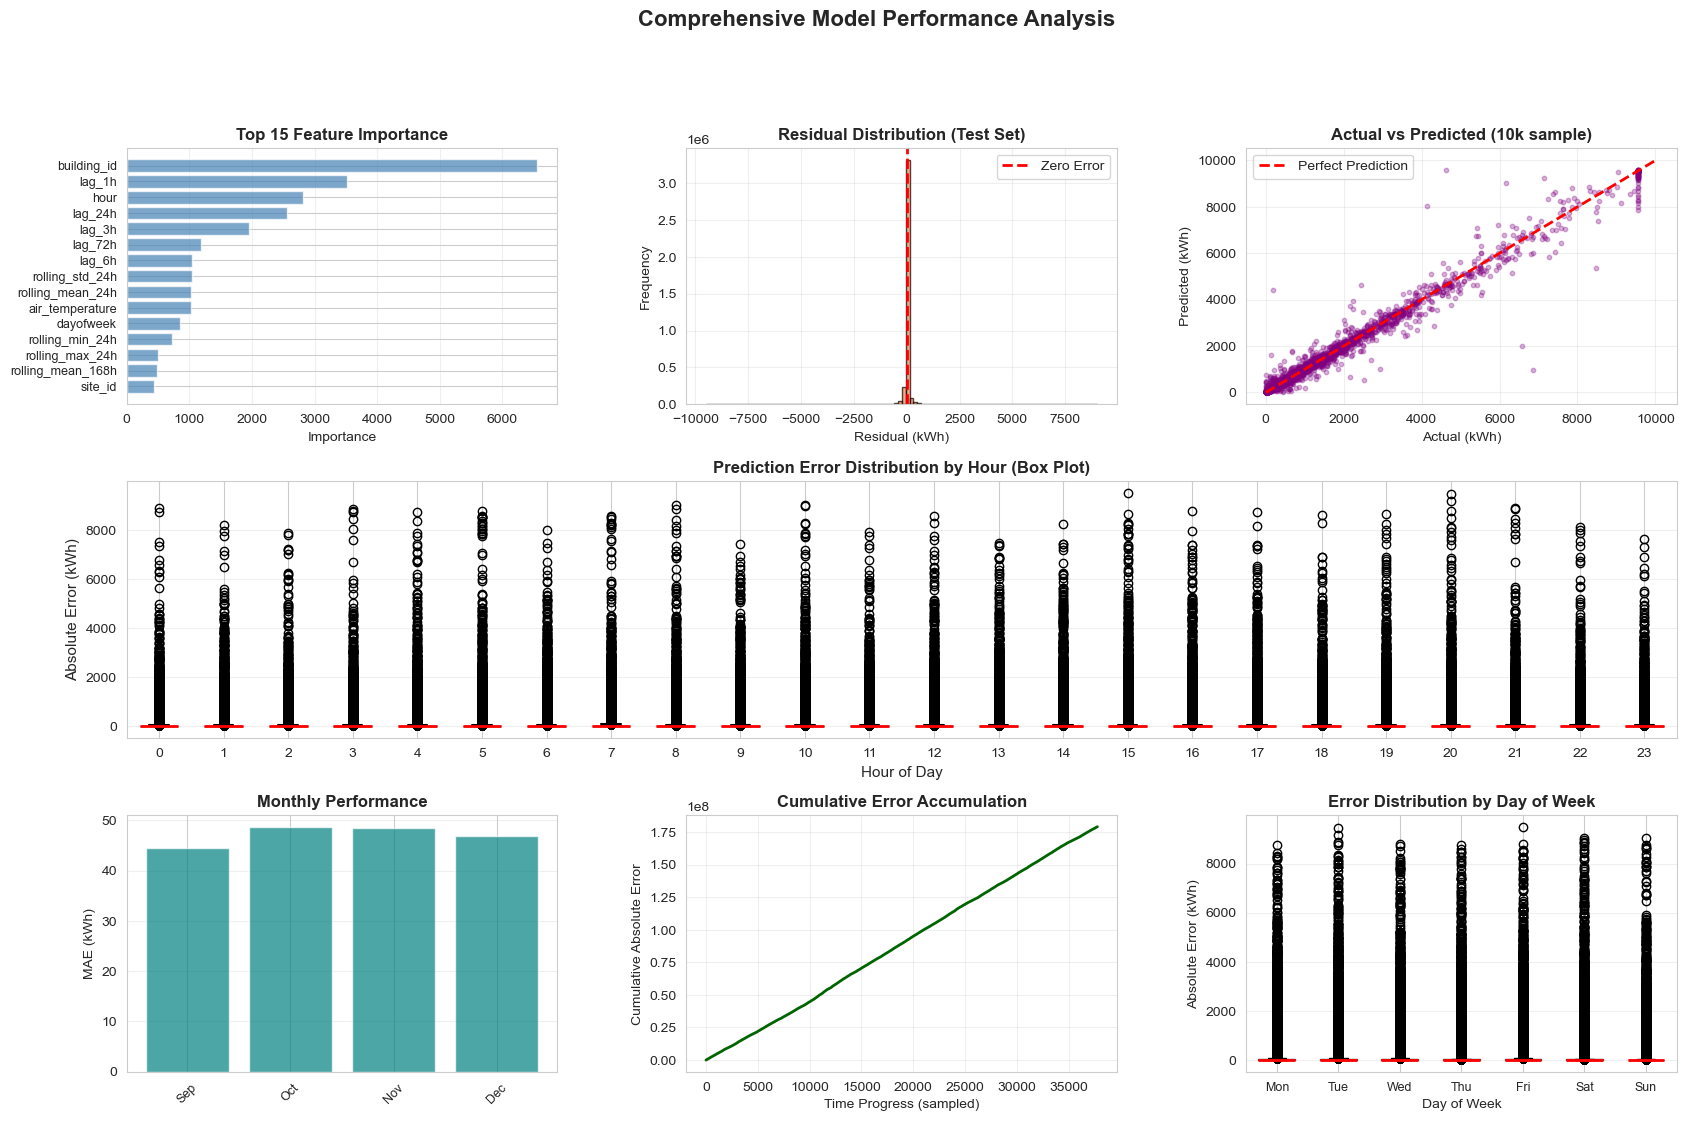


✅ Enhanced visualizations complete!
   • Feature importance ranking
   • Residual distribution analysis
   • Actual vs Predicted scatter
   • Hourly error box plots
   • Monthly performance trends
   • Cumulative error tracking
   • Day-of-week error patterns


In [104]:
# 11. COMPREHENSIVE PERFORMANCE VISUALIZATIONS
print("\n11. COMPREHENSIVE PERFORMANCE ANALYSIS & VISUALIZATIONS")
print("-"*80)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Create 6-subplot figure for comprehensive analysis
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Feature Importance (Top 15)
ax1 = fig.add_subplot(gs[0, 0])
top_features = importance_df.head(15)
ax1.barh(range(len(top_features)), top_features['importance'].values, color='steelblue', alpha=0.7)
ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['feature'].values, fontsize=9)
ax1.set_xlabel('Importance', fontsize=10)
ax1.set_title('Top 15 Feature Importance', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3, axis='x')

# 2. Residual Distribution
ax2 = fig.add_subplot(gs[0, 1])
residuals = test_analysis['residual'].values
ax2.hist(residuals, bins=100, color='coral', alpha=0.7, edgecolor='black')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.set_xlabel('Residual (kWh)', fontsize=10)
ax2.set_ylabel('Frequency', fontsize=10)
ax2.set_title('Residual Distribution (Test Set)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Actual vs Predicted Scatter (sample for visibility)
ax3 = fig.add_subplot(gs[0, 2])
sample_idx = np.random.choice(len(test_analysis), size=min(10000, len(test_analysis)), replace=False)
ax3.scatter(test_analysis.iloc[sample_idx]['meter_reading'], 
           test_analysis.iloc[sample_idx]['prediction'], 
           alpha=0.3, s=10, color='purple')
max_val = max(test_analysis['meter_reading'].max(), test_analysis['prediction'].max())
ax3.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')
ax3.set_xlabel('Actual (kWh)', fontsize=10)
ax3.set_ylabel('Predicted (kWh)', fontsize=10)
ax3.set_title('Actual vs Predicted (10k sample)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Error by Hour of Day (Box Plot)
ax4 = fig.add_subplot(gs[1, :])
hourly_errors = []
for hour in range(24):
    hour_mask = test_df['timestamp'].dt.hour == hour
    hourly_errors.append(test_analysis.loc[hour_mask, 'abs_error'].values)

bp = ax4.boxplot(hourly_errors, positions=range(24), widths=0.6, patch_artist=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5))
ax4.set_xlabel('Hour of Day', fontsize=11)
ax4.set_ylabel('Absolute Error (kWh)', fontsize=11)
ax4.set_title('Prediction Error Distribution by Hour (Box Plot)', fontsize=12, fontweight='bold')
ax4.set_xticks(range(24))
ax4.grid(True, alpha=0.3, axis='y')

# 5. Monthly Performance Comparison
ax5 = fig.add_subplot(gs[2, 0])
test_df_copy = test_df.copy()
test_df_copy['abs_error'] = test_analysis['abs_error'].values
monthly_mae = test_df_copy.groupby(test_df_copy['timestamp'].dt.month)['abs_error'].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax5.bar(range(len(monthly_mae)), monthly_mae.values, color='teal', alpha=0.7)
ax5.set_xticks(range(len(monthly_mae)))
ax5.set_xticklabels([months[i-1] for i in monthly_mae.index], rotation=45, fontsize=9)
ax5.set_ylabel('MAE (kWh)', fontsize=10)
ax5.set_title('Monthly Performance', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# 6. Cumulative Error Over Time
ax6 = fig.add_subplot(gs[2, 1])
temp_viz_cumulative = test_analysis.sort_values('timestamp').copy()
temp_viz_cumulative['cumulative_error'] = temp_viz_cumulative['abs_error'].cumsum()
sample_cumulative = temp_viz_cumulative.iloc[::100]  # Sample every 100th point
ax6.plot(range(len(sample_cumulative)), sample_cumulative['cumulative_error'].values, 
         color='darkgreen', linewidth=2)
ax6.set_xlabel('Time Progress (sampled)', fontsize=10)
ax6.set_ylabel('Cumulative Absolute Error', fontsize=10)
ax6.set_title('Cumulative Error Accumulation', fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3)

# 7. Error Percentiles by Day of Week
ax7 = fig.add_subplot(gs[2, 2])
dow_errors = []
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for dow in range(7):
    dow_mask = test_df['timestamp'].dt.dayofweek == dow
    dow_errors.append(test_analysis.loc[dow_mask, 'abs_error'].values)

bp2 = ax7.boxplot(dow_errors, positions=range(7), widths=0.6, patch_artist=True,
                  boxprops=dict(facecolor='lightyellow', alpha=0.7),
                  medianprops=dict(color='red', linewidth=2))
ax7.set_xlabel('Day of Week', fontsize=10)
ax7.set_ylabel('Absolute Error (kWh)', fontsize=10)
ax7.set_title('Error Distribution by Day of Week', fontsize=12, fontweight='bold')
ax7.set_xticklabels(dow_labels, fontsize=9)
ax7.grid(True, alpha=0.3, axis='y')

plt.suptitle('Comprehensive Model Performance Analysis', fontsize=16, fontweight='bold', y=0.995)

comprehensive_plot_path = f'../reports/comprehensive_analysis_{timestamp}.png'
plt.savefig(comprehensive_plot_path, dpi=300, bbox_inches='tight')
print(f"   ✓ Comprehensive analysis saved: {comprehensive_plot_path}")
plt.show()

print(f"\n✅ Enhanced visualizations complete!")
print(f"   • Feature importance ranking")
print(f"   • Residual distribution analysis")
print(f"   • Actual vs Predicted scatter")
print(f"   • Hourly error box plots")
print(f"   • Monthly performance trends")
print(f"   • Cumulative error tracking")
print(f"   • Day-of-week error patterns")

## Part 3: Rolling Window Backtesting (Seasonal Validation)
### Train incrementally and forecast next month to expose seasonal failures

In [105]:
print("\n12. ROLLING WINDOW BACKTESTING - SEASONAL VALIDATION")
print("-"*80)

# Prepare data with month column for rolling window
df_backtest = df.copy()
df_backtest['month'] = df_backtest['timestamp'].dt.month

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
rolling_results = []

print("\nStarting rolling window backtesting...")
print("Format: Train on months 1-N → Forecast month N+1")
print("Using ENHANCED model parameters (reduced overfitting)\n")

# Start from month 2 (need at least Jan for training)
for forecast_month in range(2, 13):  # Feb to Dec
    # Training data: all months up to (forecast_month - 1)
    train_data = df_backtest[df_backtest['month'] < forecast_month].copy()
    
    # Test data: forecast_month only
    test_data = df_backtest[df_backtest['month'] == forecast_month].copy()
    
    if len(test_data) == 0:
        print(f"⚠️ No data for {month_names[forecast_month-1]} - skipping")
        continue
    
    # Prepare X, y
    X_train_roll = train_data[model_features_all]
    y_train_roll = train_data['meter_reading']
    X_test_roll = test_data[model_features_all]
    y_test_roll = test_data['meter_reading']
    
    # Create LightGBM datasets
    train_set = lgb.Dataset(X_train_roll, label=y_train_roll)
    test_set = lgb.Dataset(X_test_roll, label=y_test_roll, reference=train_set)
    
    # Train with ENHANCED parameters (same as main model)
    model_roll = lgb.train(
        params,  # Using enhanced params from main model
        train_set,
        num_boost_round=500,
        valid_sets=[test_set],
        valid_names=['validation'],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    
    # Predict
    y_pred_roll = model_roll.predict(X_test_roll)
    
    # Calculate metrics
    rmse_roll = np.sqrt(mean_squared_error(y_test_roll, y_pred_roll))
    mae_roll = mean_absolute_error(y_test_roll, y_pred_roll)
    r2_roll = r2_score(y_test_roll, y_pred_roll)
    
    # Store results
    train_months_str = '-'.join(month_names[:forecast_month-1])
    rolling_results.append({
        'forecast_month': forecast_month,
        'forecast_month_name': month_names[forecast_month-1],
        'train_months': train_months_str,
        'train_size': len(train_data),
        'test_size': len(test_data),
        'rmse': rmse_roll,
        'mae': mae_roll,
        'r2': r2_roll
    })
    
    print(f"✓ Train on {train_months_str:20s} → Forecast {month_names[forecast_month-1]:3s} | RMSE: {rmse_roll:7.2f} | MAE: {mae_roll:6.2f} | R²: {r2_roll:.4f}")

# Create results dataframe
rolling_df = pd.DataFrame(rolling_results)
print(f"\n✅ Rolling window backtesting complete: {len(rolling_df)} forecasts")


12. ROLLING WINDOW BACKTESTING - SEASONAL VALIDATION
--------------------------------------------------------------------------------

Starting rolling window backtesting...
Format: Train on months 1-N → Forecast month N+1
Using ENHANCED model parameters (reduced overfitting)


Starting rolling window backtesting...
Format: Train on months 1-N → Forecast month N+1
Using ENHANCED model parameters (reduced overfitting)

✓ Train on Jan                  → Forecast Feb | RMSE:  174.91 | MAE:  42.94 | R²: 0.9858
✓ Train on Jan                  → Forecast Feb | RMSE:  174.91 | MAE:  42.94 | R²: 0.9858
✓ Train on Jan-Feb              → Forecast Mar | RMSE:  190.69 | MAE:  51.31 | R²: 0.9798
✓ Train on Jan-Feb              → Forecast Mar | RMSE:  190.69 | MAE:  51.31 | R²: 0.9798
✓ Train on Jan-Feb-Mar          → Forecast Apr | RMSE:  192.59 | MAE:  50.48 | R²: 0.9775
✓ Train on Jan-Feb-Mar          → Forecast Apr | RMSE:  192.59 | MAE:  50.48 | R²: 0.9775
✓ Train on Jan-Feb-Mar-Apr      → For


SEASONAL PERFORMANCE ANALYSIS

✅ BEST FORECAST:
   Month: Jun
   RMSE: 166.40 kWh
   MAE: 44.32 kWh
   R²: 0.9851

❌ WORST FORECAST:
   Month: Apr
   RMSE: 192.59 kWh
   MAE: 50.48 kWh
   R²: 0.9775

🌡️ SEASONAL COMPARISON:
   Winter avg RMSE (Feb, Dec): 175.06 kWh
   Summer avg RMSE (Jun, Jul, Aug): 178.29 kWh
   ✅ Balanced seasonal performance

✅ Saved: ../reports/rolling_window_backtest_20251109_200645.csv

✅ Saved: ../reports/rolling_window_seasonal_analysis_20251109_200645.png

✅ Saved: ../reports/rolling_window_seasonal_analysis_20251109_200645.png


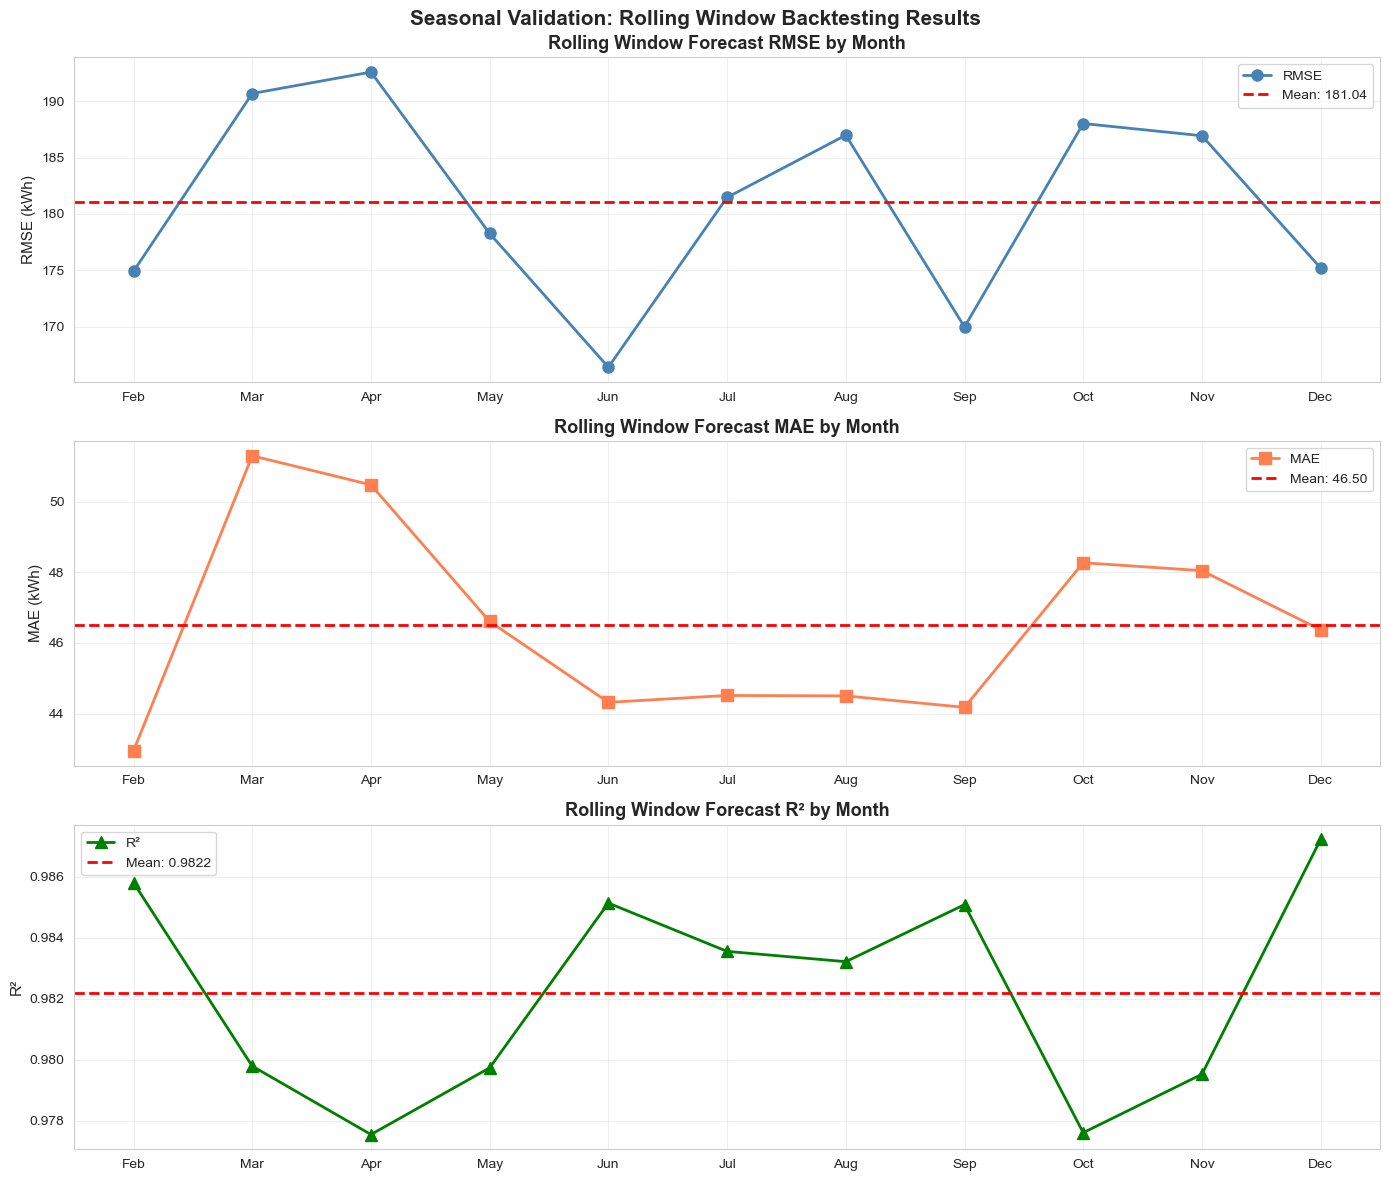


ROLLING WINDOW BACKTESTING SUMMARY

📊 SEASONAL STABILITY:
   RMSE variability across months: ± 8.73 kWh
   RMSE range: 26.19 kWh (Apr - Jun)
   ✅ Consistent performance across seasons

✅ Rolling window backtesting complete!
   NOTE: Each forecast month uses enhanced model parameters (num_leaves=48, max_depth=8, lambda=0.3)
   Models are retrained incrementally to respect temporal causality


In [107]:
# Seasonal Analysis
print("\n" + "="*80)
print("SEASONAL PERFORMANCE ANALYSIS")
print("="*80)

# Identify best/worst months
best_month = rolling_df.loc[rolling_df['rmse'].idxmin()]
worst_month = rolling_df.loc[rolling_df['rmse'].idxmax()]

print(f"\n✅ BEST FORECAST:")
print(f"   Month: {best_month['forecast_month_name']}")
print(f"   RMSE: {best_month['rmse']:.2f} kWh")
print(f"   MAE: {best_month['mae']:.2f} kWh")
print(f"   R²: {best_month['r2']:.4f}")

print(f"\n❌ WORST FORECAST:")
print(f"   Month: {worst_month['forecast_month_name']}")
print(f"   RMSE: {worst_month['rmse']:.2f} kWh")
print(f"   MAE: {worst_month['mae']:.2f} kWh")
print(f"   R²: {worst_month['r2']:.4f}")

# Seasonal patterns (winter vs summer)
winter_months = [2, 12]  # Feb, Dec (Jan not forecasted)
summer_months = [6, 7, 8]   # Jun, Jul, Aug

winter_perf = rolling_df[rolling_df['forecast_month'].isin(winter_months)]['rmse'].mean()
summer_perf = rolling_df[rolling_df['forecast_month'].isin(summer_months)]['rmse'].mean()

print(f"\n🌡️ SEASONAL COMPARISON:")
print(f"   Winter avg RMSE (Feb, Dec): {winter_perf:.2f} kWh")
print(f"   Summer avg RMSE (Jun, Jul, Aug): {summer_perf:.2f} kWh")

if abs(winter_perf - summer_perf) > 20:
    print(f"   ⚠️ SIGNIFICANT seasonal imbalance detected!")
    if winter_perf > summer_perf:
        print(f"   → Winter predictions are {winter_perf - summer_perf:.2f} kWh worse")
    else:
        print(f"   → Summer predictions are {summer_perf - winter_perf:.2f} kWh worse")
else:
    print(f"   ✅ Balanced seasonal performance")

# Save rolling results
rolling_df.to_csv(f'../reports/rolling_window_backtest_{timestamp}.csv', index=False)
print(f"\n✅ Saved: ../reports/rolling_window_backtest_{timestamp}.csv")

# Visualize Rolling Window Results
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

months_viz = rolling_df['forecast_month_name'].values
x_pos = np.arange(len(months_viz))

# RMSE over months
axes[0].plot(x_pos, rolling_df['rmse'].values, marker='o', linewidth=2, markersize=8, color='steelblue', label='RMSE')
axes[0].axhline(y=rolling_df['rmse'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rolling_df["rmse"].mean():.2f}')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(months_viz, fontsize=10)
axes[0].set_ylabel('RMSE (kWh)', fontsize=11)
axes[0].set_title('Rolling Window Forecast RMSE by Month', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# MAE over months
axes[1].plot(x_pos, rolling_df['mae'].values, marker='s', linewidth=2, markersize=8, color='coral', label='MAE')
axes[1].axhline(y=rolling_df['mae'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rolling_df["mae"].mean():.2f}')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(months_viz, fontsize=10)
axes[1].set_ylabel('MAE (kWh)', fontsize=11)
axes[1].set_title('Rolling Window Forecast MAE by Month', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# R² over months
axes[2].plot(x_pos, rolling_df['r2'].values, marker='^', linewidth=2, markersize=8, color='green', label='R²')
axes[2].axhline(y=rolling_df['r2'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rolling_df["r2"].mean():.4f}')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(months_viz, fontsize=10)
axes[2].set_ylabel('R²', fontsize=11)
axes[2].set_title('Rolling Window Forecast R² by Month', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.suptitle('Seasonal Validation: Rolling Window Backtesting Results', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig(f'../reports/rolling_window_seasonal_analysis_{timestamp}.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Saved: ../reports/rolling_window_seasonal_analysis_{timestamp}.png")
plt.show()

# Final Summary
print("\n" + "="*80)
print("ROLLING WINDOW BACKTESTING SUMMARY")
print("="*80)
print(f"\n📊 SEASONAL STABILITY:")
rmse_std = rolling_df['rmse'].std()
rmse_range = rolling_df['rmse'].max() - rolling_df['rmse'].min()
print(f"   RMSE variability across months: ± {rmse_std:.2f} kWh")
print(f"   RMSE range: {rmse_range:.2f} kWh ({worst_month['forecast_month_name']} - {best_month['forecast_month_name']})")

if rmse_range > 50:
    print(f"   ⚠️ HIGH seasonal variability detected")
    print(f"   → Worst month: {worst_month['forecast_month_name']} (RMSE: {worst_month['rmse']:.2f})")
    print(f"   → Consider: Add more weather features or season-specific models")
else:
    print(f"   ✅ Consistent performance across seasons")

print(f"\n✅ Rolling window backtesting complete!")
print(f"   NOTE: Each forecast month uses enhanced model parameters (num_leaves=48, max_depth=8, lambda=0.3)")
print(f"   Models are retrained incrementally to respect temporal causality")